In [99]:
from __future__ import division
from __future__ import print_function

import argparse
import collections
import datetime
import itertools
import os.path
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from math import ceil,sqrt
from scipy.stats import entropy

In [100]:

filepath = "C:/Users/Jazzy/Academia/ML/lastfm/user_taggedartists-timestamps.dat"
train_file = "train.txt"
valid_file = "valid.txt"

ENTROPY_CUTOFF = 3.0

MIN_OCCURRENCES = 10
MIN_VALID_SEQ_LEN = 4
#MAX_VALID_SEQ_LEN = 500

def processdata():
    data = list()
    i_occ = collections.defaultdict(lambda: 0)
    with open(filepath, 'r') as f:
        for i,line in enumerate(f):
            if i == 0:
                continue
            uid, aid, tid, ts = line.strip().split('\t')
            data.append((uid,aid,tid,ts))
            i_occ[aid] += 1
        
    tmp_data = collections.defaultdict(list)
    for uid,aid,tid,ts in data:
        if i_occ[aid] > MIN_OCCURRENCES:
            tmp_data[uid].append((ts,aid,tid))
            
    seq_data = dict()
    for uid in tmp_data:
        seq = [(aid,tid) for ts,aid,tid in sorted(tmp_data[uid])]
        seq_data[uid] = seq
        
    train = dict()
    valid = dict()
    for user,seq in seq_data.items():
        if len(seq) > MIN_OCCURRENCES:
            cutoff = max(MIN_VALID_SEQ_LEN, int(round(0.25 * len(seq))))
            train[user] = seq[:-cutoff]
            valid[user] = seq[-cutoff:]
          
    items = list()
    tags = list()
    for x,y in itertools.chain(*train.values()):
        items.append(x)
        tags.append(y)
    items = set(items)
    tags = set(tags)
    users = set(train.keys())
    user2id = dict(zip(users, range(1,len(users)+1)))
    items2id = dict(zip(items, range(1,len(items)+1)))
    tags2id = dict(zip(tags, range(1,len(tags)+1)))
    train_data = dict()
    valid_data = dict()
    
    for user in users:
        train_data[user2id[user]] = tuple(map(lambda x: (items2id[x[0]],tags2id[x[1]]), train[user]))
        valid_data[user2id[user]] = tuple(map(lambda x: (items2id[x[0]],tags2id[x[1]]),
                                             filter(lambda x: x[0] in items and x[1] in tags, valid[user])))
        
    with open(train_file, "w") as t, open(valid_file, "w") as v:
        for uid in user2id.values():
            for aid,tid in train_data[uid]:
                t.write("{} {} {}\n".format(uid, aid, tid))
            for aid,tid in valid_data[uid]:
                v.write("{} {} {}\n".format(uid, aid, tid))
                

processdata()  

In [101]:
class Dataset(object):

    def __init__(self, num_users, num_items, num_tags, seq_dict):
        self._seq_dict = seq_dict
        self._num_users = num_users
        self._num_items = num_items
        self._num_tags = num_tags
        # These variables are set after calling `prepare_batches`.
        self._users_in_batches = None
        self._batches = None
        self._seq_lengths = None
        self._chunk_size = None

    @property
    def num_users(self):
        return self._num_users

    @property
    def num_items(self):
        return self._num_items
    
    @property
    def num_tags(self):
        return self._num_tags

    @property
    def num_triplets(self):
        return sum(len(seq) for u, seq in self.sequences())

    @property
    def num_batches(self):
        if self._batches is None:
            raise RuntimeError("`prepare_batches` has not been called yet.")
        return len(self._batches)

    @property
    def users_in_batches(self):
        if self._users_in_batches is None:
            raise RuntimeError("`prepare_batches` has not been called yet.")
        return self._users_in_batches
    
    def __getitem__(self, u):
        return self._seq_dict[u]

    def sequences(self):
        return self._seq_dict.items()

    def iter_batches(self, order=None):
        if order is None:
            order = range(self.num_batches)
        if self._batches is None:
            raise RuntimeError("`prepare_batches` has not been called yet.")
        cs = self._chunk_size
        def iter_batch(batch, seq_length):
            num_cols = batch.shape[1]
            for i, z in enumerate(range(0, num_cols - 1, cs)):
                inputs = batch[:,z:z+cs,:]
                targets = batch[:,(z+1):(z+cs+1),1]
                yield (inputs, targets, seq_length[:,i])
        for i in order:
            yield iter_batch(self._batches[i], self._seq_lengths[i])

    def prepare_batches(self, chunk_size, batch_size, batches_like=None):
        # Spread users over batches.
        if batches_like is not None:
            self._users_in_batches = batches_like.users_in_batches
        else:
            self._users_in_batches = Dataset._assign_users_to_batches(
                    batch_size, self._seq_dict)
        # Build the batches and record the corresponding valid sequence lengths.
        self._chunk_size = chunk_size
        self._batches = list()
        self._seq_lengths = list()
        for users in self._users_in_batches:
#           print("users :",users)
            lengths = tuple(len(self[u]) for u in users)
#           print("lengths: ",lengths)
            num_chunks = int(ceil(max(max(lengths) - 1, chunk_size)
                    / chunk_size))
            num_cols = num_chunks * chunk_size + 1
#           print("number of columns: ",num_cols)
            batch = np.zeros((batch_size, num_cols, 3), dtype=np.int32)
            seq_length = np.zeros((batch_size, num_chunks), dtype=np.int32)
            for i, (user, length) in enumerate(zip(users, lengths)):
                # Assign the values to the batch.
                batch[i,:length,0] = user
                batch[i,:length,1:] = self[user]
#               print("self[user]",user,self[user])
                # Compute and assign the valid sequence lengths.
                q, r = divmod(max(0, min(num_cols, length) - 1), chunk_size)
                seq_length[i,:q] = chunk_size
                if r > 0:
                    seq_length[i,q] = r
#           print("batch: ", batch)
            self._batches.append(batch)
            self._seq_lengths.append(seq_length)

    @staticmethod
    def _assign_users_to_batches(batch_size, seq_dict):
        lengths, users = zip(*sorted(((len(seq), u)
                for u, seq in seq_dict.items()), reverse=True))
        return tuple(users[i:i+batch_size]
                for i in range(0, len(users), batch_size))

    @classmethod
    def from_path(cls, path):
        data = collections.defaultdict(list)
        num_users = 0
        num_items = 0
        num_tags = 0
        with open(path) as f:
            for line in f:
                u, i, t = map(int, line.strip().split())
                num_users = max(u, num_users)  # Users are numbered 1 -> N.
                num_items = max(i, num_items)  # Items are numbered 1 -> M.
                num_tags = max(t, num_tags) # Tags are numbered 1 -> T
                data[u].append((i,t))
        sequence = dict()
        for user in range(1, num_users + 1):
            if user in data:
                sequence[user] = np.array(data[user])
            else:
                sequence[user] = np.array([[0,0]])
        return cls(num_users, num_items, num_tags, sequence)


In [102]:
class CGRUCell(tf.contrib.rnn.RNNCell):

    def __init__(self, num_units, num_users, num_items, num_tags):
        """Note: users are numbered 1 to N, items are numbered 1 to M. User and
        item "zero" is reserved for padding purposes.
        """
        self._num_units = num_units
        self._num_users = num_users
        self._num_items = num_items
        self._num_tags = num_tags

    @property
    def state_size(self):
        return self._num_units

    @property
    def output_size(self):
        return self._num_units

    def __call__(self, inputs, state, scope=None):
        # shape(inputs) = [batch_size, input_size]
        # shape(state) = [batch_size, num_units]

        with tf.variable_scope(scope or type(self).__name__):  # "CollaborativeGRUCell"
            with tf.variable_scope("Gates"):
                with tf.device("/cpu:0"):
                    users = tf.get_variable("users",
                            [self._num_users + 1, self._num_units, 2 * self._num_units],
                            dtype=tf.float32)
                    # shape(w_hidden_u) = [batch_size, num_units, 2 * num_units]
                    w_hidden_u = tf.nn.embedding_lookup(users, inputs[:,0])
                    items = tf.get_variable("items",
                            [self._num_items + 1, 2 * self._num_units],
                            dtype=tf.float32)
                    # shape(w_input_i) = [batch_size, 2 * num_units]
                    w_input_i = tf.nn.embedding_lookup(items, inputs[:,1])
                    #tags = tf.get_variable("tags",
                    #        [self._num_tags + 1, 2 * self._num_units],
                    #        dtype=tf.float32)
                    # shape(w_input_t) = [batch_size, 2 * num_units]
                    #w_input_t = tf.nn.embedding_lookup(tags, inputs[:,2])
                res = tf.matmul(tf.expand_dims(state, 1), w_hidden_u)
                res = tf.sigmoid(tf.squeeze(res, [1]) + w_input_i)# + w_input_t)
                r, z = tf.split(axis=1, num_or_size_splits=2, value=res)
            with tf.variable_scope("Candidate"):
                with tf.device("/cpu:0"):
                    users = tf.get_variable("users",
                            [self._num_users + 1, self._num_units, self._num_units],
                            dtype=tf.float32)
                    # shape(w_hidden_u) = [batch_size, num_units, num_units]
                    w_hidden_u = tf.nn.embedding_lookup(users, inputs[:,0])
                    items = tf.get_variable("items",
                            [self._num_items + 1, self._num_units],
                            dtype=tf.float32)
                    # shape(w_input_i) = [batch_size, num_units]
                    w_input_i = tf.nn.embedding_lookup(items, inputs[:,1])
                    #tags = tf.get_variable("tags",
                    #        [self._num_tags + 1, self._num_units],
                    #        dtype=tf.float32)
                    # shape(w_input_t) = [batch_size, num_units]
                    #w_input_t = tf.nn.embedding_lookup(tags, inputs[:,2])
                res = tf.matmul(tf.expand_dims(r * state, 1), w_hidden_u)
                # check with tanh and relu
                c = tf.sigmoid(tf.squeeze(res, [1]) + w_input_i)# + w_input_t)
            new_h = z * state + (1 - z) * c
        return new_h, new_h


log-loss: 8.452 speed: 1948 wps
log-loss: 8.421 speed: 2168 wps
log-loss: 8.356 speed: 2196 wps
log-loss: 8.344 speed: 2262 wps
log-loss: 8.351 speed: 2275 wps
log-loss: 8.299 speed: 2270 wps
log-loss: 8.283 speed: 2266 wps
log-loss: 8.262 speed: 2312 wps
log-loss: 8.276 speed: 2311 wps
Epoch 1, train log-loss: 8.265, train eff: 0.01317677400606622
Epoch 1, valid log-loss: 7.706, valid eff: 0.014844402050792894
log-loss: 6.835 speed: 1965 wps
log-loss: 6.996 speed: 2143 wps
log-loss: 6.979 speed: 2156 wps
log-loss: 6.974 speed: 2166 wps
log-loss: 6.964 speed: 2134 wps
log-loss: 6.959 speed: 2241 wps
log-loss: 6.964 speed: 2279 wps
log-loss: 6.933 speed: 2309 wps
log-loss: 6.903 speed: 2254 wps
Epoch 2, train log-loss: 6.890, train eff: 0.07363010588641276
Epoch 2, valid log-loss: 7.088, valid eff: 0.039495648026708
log-loss: 6.034 speed: 2617 wps
log-loss: 5.752 speed: 2388 wps
log-loss: 5.729 speed: 2494 wps
log-loss: 5.680 speed: 2393 wps
log-loss: 5.586 speed: 2371 wps
log-loss: 5.5

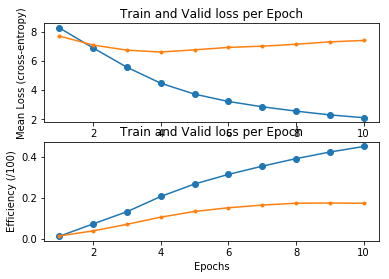

In [107]:
class CollaborativeRecc(object):

    def __init__(self, num_users, num_items, num_tags, is_training,
            chunk_size=128, batch_size=1, hidden_size=128,
            learning_rate=0.1, rho=0.9):
        
        self._batch_size = batch_size

        # placeholders for input data
        self._inputs = tf.placeholder(tf.int32, name="inputs",
                shape=[batch_size, chunk_size, 3])
        self._targets = tf.placeholder(tf.int32, name="targets",
                shape=[batch_size, chunk_size])
        self._seq_length = tf.placeholder(tf.int32, name="seq_length",
                shape=[batch_size])

        # RNN cell.
        cell = CGRUCell(hidden_size, num_users, num_items, num_tags)
        self._initial_state = cell.zero_state(batch_size, tf.float32)

        inputs = [tf.squeeze(input_, [1]) for input_
                in tf.split(axis=1, num_or_size_splits=chunk_size, value=self._inputs)]
        #[O]states, _ = tf.nn.rnn(cell, inputs,
        #        initial_state=self._initial_state)

        states, _ = tf.contrib.rnn.static_rnn(cell, inputs,
                initial_state=self._initial_state)      #[N]

        # Compute the final state for each element of the batch.
        self._final_state = tf.gather_nd([self._initial_state] + states,
                tf.transpose(tf.stack([self._seq_length, tf.range(batch_size)])))

        # Output layer.
        # `output` has shape (batch_size * chunk_size, hidden_size).
        output = tf.reshape(tf.concat(axis=1, values=states), [-1, hidden_size])
        with tf.variable_scope("output"):
            ws = tf.get_variable("weights", [hidden_size, num_items + 1],
                                 dtype=tf.float32)
        # `logits` has shape (batch_size * chunk_size, num_items).
        logits = tf.matmul(output, ws)
        targets = tf.reshape(self._targets, [-1])
        
        predictions = tf.nn.softmax(logits)
        self._predicts = tf.argmax(
            tf.reshape(predictions, [batch_size,chunk_size,num_items+1]), 2)

        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets)

        masked = loss * tf.to_float(tf.sign(targets))
        masked = tf.reshape(masked, [batch_size, chunk_size])
        self._cost = tf.reduce_sum(masked, axis=1)

        if not is_training:
            self._train_op = tf.no_op()
            return

        scalar_cost = tf.reduce_mean(masked)

        # Optimization procedure.
        optimizer = tf.train.RMSPropOptimizer(
                learning_rate, decay=rho, epsilon=1e-8)
        self._train_op = optimizer.minimize(scalar_cost)
        
        self._rms_reset = list()
        for var in tf.trainable_variables():
            slot = optimizer.get_slot(var, "rms")
            op = slot.assign(tf.zeros(slot.get_shape()))
            self._rms_reset.append(op)

    @property
    def inputs(self):
        return self._inputs

    @property
    def targets(self):
        return self._targets

    @property
    def seq_length(self):
        return self._seq_length

    @property
    def initial_state(self):
        return self._initial_state

    @property
    def final_state(self):
        return self._final_state

    @property
    def cost(self):
        return self._cost
    
    @property
    def outputs(self):
        return self._predicts

    @property
    def train_op(self):
        return self._train_op

    @property
    def batch_size(self):
        return self._batch_size

    @property
    def rms_reset(self):
        return self._rms_reset


def run_batch(session, model, iterator, initial_state):
    """Runs the model on all chunks of one batch."""
    costs = np.zeros(model.batch_size)
    sizes = np.zeros(model.batch_size)
    correct = 0
    state = initial_state
    for inputs, targets, seq_len in iterator:
        fetches = [model.cost, model.outputs, model.final_state, model.train_op]
        feed_dict = {}
        feed_dict[model.inputs] = inputs
        feed_dict[model.targets] = targets
        feed_dict[model.seq_length] = seq_len
        feed_dict[model.initial_state] = state
        cost, outputs, state, _ = session.run(fetches, feed_dict)
        costs += cost
        sizes += seq_len
        correct += np.sum(outputs == targets)
    with np.errstate(invalid='ignore'):
        errors = costs / sizes
    return (errors, np.sum(sizes), state, correct)


def run_epoch(session, train_model, valid_model, train_iter, valid_iter,
        tot_size):
    """Runs the model on the given data."""
    start_time = time.time()

    train_errors = list()
    valid_errors = list()
    tot = 0
    train_correct = 0
    train_seq_len = 0
    valid_correct = 0
    valid_seq_len = 0

    next_tenth = tot_size / 10

    for train, valid in zip(train_iter, valid_iter):
        state = session.run(train_model.initial_state)
        # Training data.
        errors, num_triplets, state, correct = run_batch(
                session, train_model, train, state)
        tot += num_triplets
        train_seq_len += num_triplets
        train_correct += correct
        train_errors.extend(errors)
        # Validation data.
        errors, num_triplets, state, correct = run_batch(
                session, valid_model, valid, state)
        tot += num_triplets
        valid_seq_len += num_triplets
        valid_correct += correct
        valid_errors.extend(errors)

        if tot > next_tenth:
            print("log-loss: {:.3f} speed: {:.0f} wps".format(
                    np.nanmean(train_errors),
                    tot / (time.time() - start_time)))
            next_tenth += tot_size / 10
            
        train_eff = train_correct/train_seq_len
        valid_eff = valid_correct/valid_seq_len

    return (np.nanmean(train_errors), np.nanmean(valid_errors),
           train_eff, valid_eff)

def main(train_path,valid_path,bs=5,cs=64,hs=128,lr=0.01,
         epochs=10,rho=0.9):

    train_data = Dataset.from_path(train_path)
    valid_data = Dataset.from_path(valid_path)
    
    num_users = train_data.num_users
    num_items = train_data.num_items
    num_tags = train_data.num_tags
    tot_size = train_data.num_triplets + valid_data.num_triplets

    train_data.prepare_batches(cs, bs)
    valid_data.prepare_batches(cs, bs, batches_like=train_data)

    settings = {
        "chunk_size": cs,
        "batch_size": bs,
        "hidden_size": hs,
        "learning_rate": lr,
        "rho": rho,
    }
    
    train_loss = list()
    valid_loss = list()
    _train_eff = list()
    _valid_eff = list()

    with tf.Graph().as_default(), tf.Session() as session:
        initializer = tf.random_normal_initializer(
                mean=0, stddev=1/sqrt(hs))
        with tf.variable_scope("model", reuse=None, initializer=initializer):
            train_model = CollaborativeRecc(num_users, num_items, num_tags,
                    is_training=True, **settings)
        with tf.variable_scope("model", reuse=True, initializer=initializer):
            valid_model = CollaborativeRecc(num_users, num_items, num_tags,
                    is_training=False, **settings)
        tf.global_variables_initializer().run()
        session.run(train_model.rms_reset)
        for i in range(1, epochs + 1):
            order = np.random.permutation(train_data.num_batches)
            train_iter = train_data.iter_batches(order=order)
            valid_iter = valid_data.iter_batches(order=order)

            train_err, valid_err, train_eff, valid_eff = run_epoch(session, train_model, valid_model,
                    train_iter, valid_iter, tot_size)
            train_loss.append(train_err)
            valid_loss.append(valid_err)
            _train_eff.append(train_eff)
            _valid_eff.append(valid_eff)
            
            print("Epoch {}, train log-loss: {:.3f}, train eff: {}".format(i, train_err, train_eff))
            print("Epoch {}, valid log-loss: {:.3f}, valid eff: {}".format(i, valid_err, valid_eff))
     
    fig, (ax0, ax1) = plt.subplots(nrows=2)

    ax0.plot(np.arange(1,epochs+1), train_loss, 'o-')
    ax0.plot(np.arange(1,epochs+1), valid_loss, '.-')
    ax0.set(xlabel='Epochs', ylabel='Mean Loss (cross-entropy)',
       title='Train and Valid loss per Epoch')
    
    ax1.plot(np.arange(1,epochs+1), _train_eff, 'o-')
    ax1.plot(np.arange(1,epochs+1), _valid_eff, '.-')
    ax1.set(xlabel='Epochs', ylabel='Efficiency (/100)',
       title='Efficiency(/100) per Epoch')
    
    plt.show()

args = {
    "train_path" : train_file,
    "valid_path" : valid_file,
    "bs" : 5,  # batch size
    "cs" : 64,  # chunk size
    "hs" : 128,  # hidden size
    "lr" : 0.01,  # learning rate
    "epochs" : 10,
    "rho" : 0.95,  # RMSProp decay coefficient
}

main(**args)
